In [1]:
import json
import os
import sys
import glob
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

My imports

In [2]:
sys.path.append(os.path.join(sys.path[0], './processing/'))
from decode import decode, translate_coords, add_bb

Locate dataset

In [3]:
train_list = glob.glob(os.path.join('./detection_dataset_v02-04/train/', '*.json'))
valid_list = glob.glob(os.path.join('./detection_dataset_v02-04/validation/', '*.json'))
test_list = glob.glob(os.path.join('./detection_dataset_v02-04/test/', '*.json'))
full_list = train_list + valid_list + test_list

Collect statistics

In [4]:
visibility = {'Visible':0, 'Occluded':0, 'Hidden':0}
game_type = {'Match':0, 'Drill':0}
ball_size = {'Small':0, 'Medium':0, 'Large':0}
ball_rads = []
ball_x = []
ball_y = []
images = []
imgnames = []

SMALL_THRES = 32
LARGE_THRES = 96 

for count, name in enumerate(full_list):

    with open(name, 'r') as input_file:
        img_dict = json.load(input_file)
        
    output_img = decode(img_dict['img'], img_dict['h_img'], img_dict['w_img'])
    m, n = output_img.shape[:2]

    ## Ball visibility ##
    if img_dict["ball_sighted"] == 1:   
        
        ball_vector = np.asarray(img_dict["ball_locate"])
        m_coord, n_coord, BALL_RAD_implane = translate_coords(output_img, ball_vector)
        
        if img_dict["occluded"] == False:
            visibility["Visible"] = visibility["Visible"] + 1
        
        elif img_dict["occluded"] == True:
            visibility["Occluded"] = visibility["Occluded"] + 1
            
        ## Ball size ##
        ball_rads.append(BALL_RAD_implane)
        ball_x.append(n_coord)
        ball_y.append(m_coord)
        add_bb(output_img,ball_vector)
        images.append(output_img)
        imgnames.append(name[name.rfind("/")+1:-5])
        
        if 2*BALL_RAD_implane <= SMALL_THRES:
            ball_size["Small"] = ball_size["Small"] + 1
            
        elif 2*BALL_RAD_implane > SMALL_THRES and 2*BALL_RAD_implane < LARGE_THRES:
            ball_size["Medium"] = ball_size["Medium"] + 1
            
        elif 2*BALL_RAD_implane > LARGE_THRES:
             ball_size["Large"] = ball_size["Large"] + 1           
               
    elif img_dict["ball_sighted"] == 0:
        visibility["Hidden"] = visibility["Hidden"] + 1
        images.append(output_img)
        imgnames.append(name[name.rfind("/")+1:-5])
       
    ## Game types ##
    if img_dict["type"] == "drill":   
        game_type["Drill"] = game_type["Drill"] + 1
            
    elif img_dict["type"] == "match":
        game_type["Match"] = game_type["Match"] + 1

Show variety

In [5]:
img_inds = []
disp_img = ["19150_outimg_WITS-FC7-4720",
            "19150_outimg_WITS-FC7-12310",
            "14817_outimg_WITS-FC2-1510",
            "12065_outimg_WITS-FC2-766",
            "12065_outimg_WITS-FC2-1356",
            "12065_outimg_WITS-FC2-432"]

for name in disp_img:
    img_inds.append(imgnames.index(name))

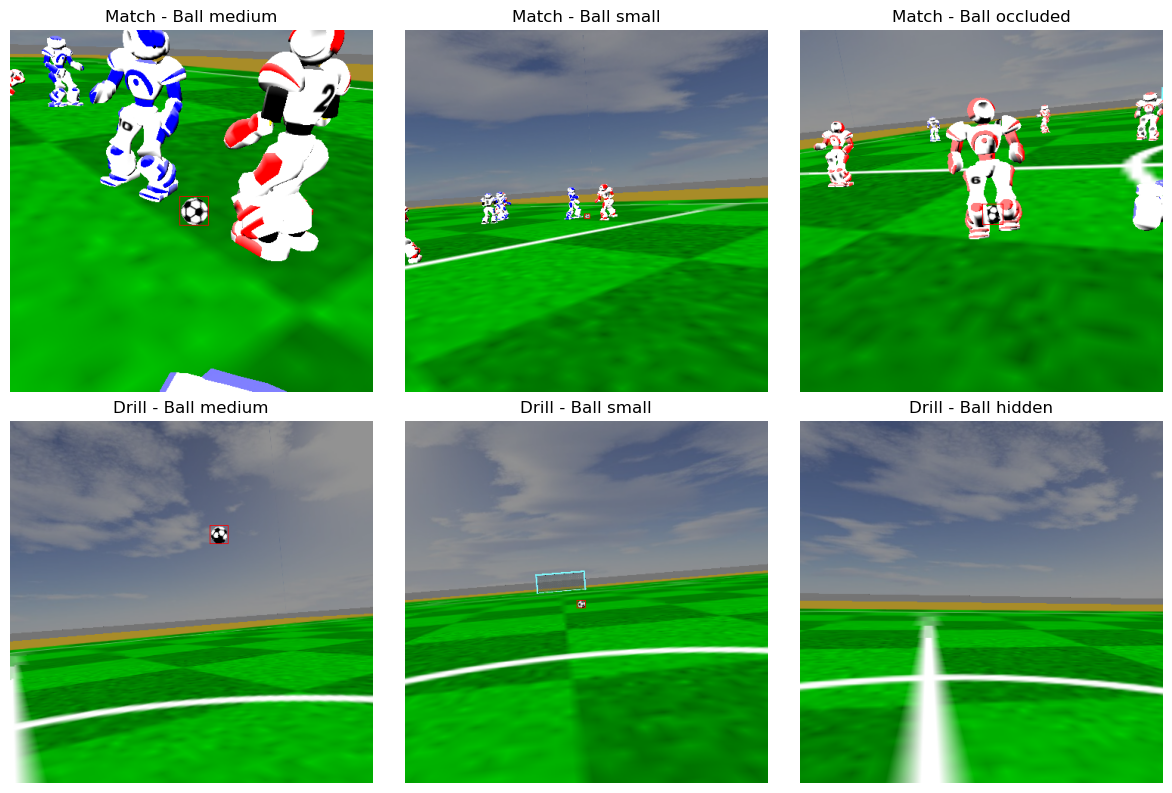

In [6]:
fig,axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex=True, sharey=True)
ax=axes.ravel()

ax[0].imshow(images[img_inds[0]])
ax[0].set_title("Match - Ball medium")
ax[1].imshow(images[img_inds[1]])
ax[1].set_title("Match - Ball small")
ax[2].imshow(images[img_inds[2]])
ax[2].set_title("Match - Ball occluded")
ax[3].imshow(images[img_inds[3]])
ax[3].set_title("Drill - Ball medium")
ax[4].imshow(images[img_inds[4]])
ax[4].set_title("Drill - Ball small")
ax[5].imshow(images[img_inds[5]])
ax[5].set_title("Drill - Ball hidden")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

Plot counts

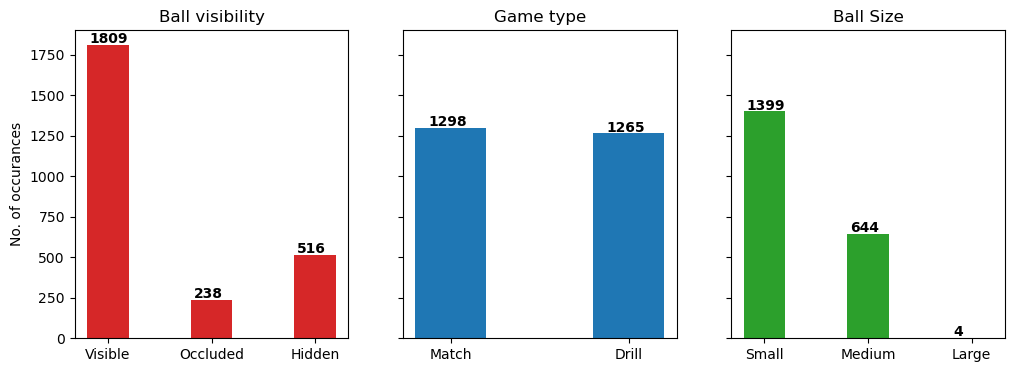

In [7]:
vis_keys = list(visibility.keys())
vis_vals = list(visibility.values())
type_keys = list(game_type.keys())
type_vals = list(game_type.values())
ball_keys = list(ball_size.keys())
ball_vals = list(ball_size.values())

fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharey=True)
ax=axes.ravel()

ax[0].bar(vis_keys, vis_vals, color = 'tab:red', width = 0.4)
ax[0].set_title("Ball visibility")
ax[0].set_ylabel("No. of occurances")
for i, v in enumerate(vis_vals):
    ax[0].text(i - 0.175, v + 10, str(v), color='k', fontweight='bold')

ax[1].bar(type_keys, type_vals, color ='tab:blue', width = 0.4)
ax[1].set_title("Game type")
for i, v in enumerate(type_vals):
    ax[1].text(i - 0.125, v + 10, str(v), color='k', fontweight='bold')

ax[2].bar(ball_keys, ball_vals, color = 'tab:green', width = 0.4)
ax[2].set_title("Ball Size")
for i, v in enumerate(ball_vals):
    ax[2].text(i - 0.175, v + 10, str(v), color='k', fontweight='bold')

#fig.tight_layout()
plt.show()

Plot object characteristics

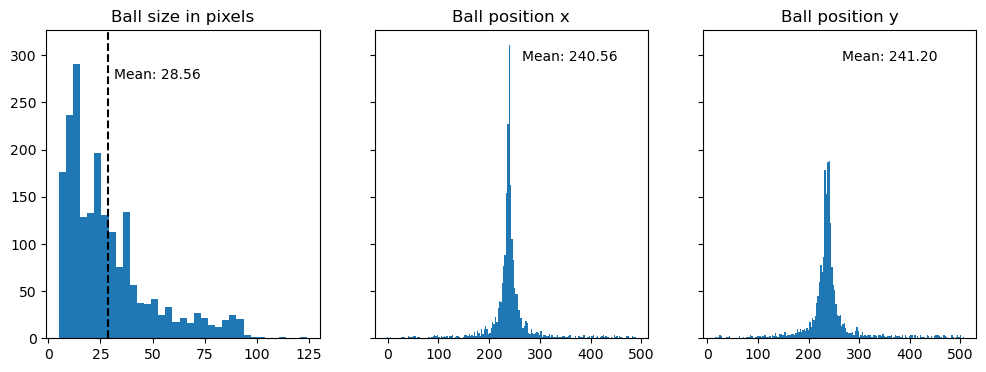

In [8]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharey=True)
ax=axes.ravel()

ball_rads = np.array(ball_rads)*2
ax[0].hist(ball_rads, bins=35)
ax[0].set_title("Ball size in pixels")
min_ylim, max_ylim = ax[0].axis()[-2:]
ax[0].axvline(ball_rads.mean(), color='k', linestyle='dashed', linewidth=1.5)
ax[0].text(ball_rads.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(ball_rads.mean()))

ball_x = np.array(ball_x)
ax[1].hist(ball_x, bins=180)
ax[1].set_title("Ball position x")
min_ylim, max_ylim = ax[1].axis()[-2:]
ax[1].text(ball_x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(ball_x.mean()))

ball_y = np.array(ball_y)
ax[2].hist(ball_y, bins=180)
ax[2].set_title("Ball position y")
min_ylim, max_ylim = ax[2].axis()[-2:]
ax[2].text(ball_y.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(ball_y.mean()))

plt.show()